# Customer Churn Analytics 

A rotatividade (churn) de clientes ocorre quando clientes ou assinantes param de fazer negócios com uma empresa ou serviço. Também é conhecido como perda de clientes ou taxa de cancelamento.

Um setor no qual saber e prever as taxas de cancelamento é particularmente útil é o setor de telecomunicações, porque a maioria dos clientes tem várias opções de escolha dentro de uma localização geográfica.

Neste projeto, vamos prever a rotatividade (churn) de clientes usando um conjunto de dados de telecomunicações. 

Usaremos a regressão logística, a árvore de decisão e a floresta aleatória como modelos de Machine Learning. 

Usaremos um dataset oferecido gratuitamente no portal IBM Sample Data Sets. 

Cada linha representa um cliente e cada coluna contém os atributos desse cliente.

https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/

In [10]:
# Definindo o diretório de trabalho
setwd("C:\\Users\\chnat\\Google Drive\\00_DATASCIENCE\\FCD\\04_BigDataRAzure\\cap06")
getwd()

[1] "C:/Users/chnat/Google Drive/00_DATASCIENCE/FCD/04_BigDataRAzure/cap06"

In [11]:
# Carregando os pacotes
library(plyr)
library(corrplot)
library(ggplot2)
library(gridExtra)
library(ggthemes)
library(caret)
library(MASS)
library(randomForest)
library(party)
library(dplyr)

##### Carregando e Limpando os Dados ##### 

In [12]:
# Os dados brutos contêm 7043 linhas (clientes) e 21 colunas (recursos). 
# A coluna "Churn" é o nosso alvo.
churn <- read.csv('Telco-Customer-Churn.csv', stringsAsFactors=TRUE)
str(churn)

'data.frame':	7043 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","

In [13]:
# Usamos sapply para verificar o número de valores ausentes (missing) em cada coluna. 
# Descobrimos que há 11 valores ausentes nas colunas "TotalCharges". 
# Então, vamos remover todas as linhas com valores ausentes.
sapply(churn, function(x) sum(is.na(x)))
churn <- churn[complete.cases(churn), ]

customerID           gender    SeniorCitizen          Partner 
               0                0                0                0 
      Dependents           tenure     PhoneService    MultipleLines 
               0                0                0                0 
 InternetService   OnlineSecurity     OnlineBackup DeviceProtection 
               0                0                0                0 
     TechSupport      StreamingTV  StreamingMovies         Contract 
               0                0                0                0 
PaperlessBilling    PaymentMethod   MonthlyCharges     TotalCharges 
               0                0                0               11 
           Churn 
               0

# Olhe para as variáveis, podemos ver que temos algumas limpezas e ajustes para fazer.

In [14]:
# 1. Vamos mudar "No internet service" para "No" por seis colunas, que são: 
# "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "streamingTV", 
# "streamingMovies".
str(churn)
cols_recode1 <- c(10:15)
for(i in 1:ncol(churn[,cols_recode1])) {
  churn[,cols_recode1][,i] <- as.factor(mapvalues
                                        (churn[,cols_recode1][,i], from =c("No internet service"),to=c("No")))
}

'data.frame':	7032 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","

In [15]:
# 2. Vamos mudar "No phone service" para "No" para a coluna "MultipleLines"
churn$MultipleLines <- as.factor(mapvalues(churn$MultipleLines, 
                                           from=c("No phone service"),
                                           to=c("No")))

In [16]:
# 3. Como a permanência mínima é de 1 mês e a permanência máxima é de 72 meses, 
# podemos agrupá-los em cinco grupos de posse (tenure): 
# "0-12 Mês", "12-24 Mês", "24-48 Meses", "48-60 Mês" Mês ","> 60 Mês"
min(churn$tenure); max(churn$tenure)

group_tenure <- function(tenure){
  if (tenure >= 0 & tenure <= 12){
    return('0-12 Month')
  }else if(tenure > 12 & tenure <= 24){
    return('12-24 Month')
  }else if (tenure > 24 & tenure <= 48){
    return('24-48 Month')
  }else if (tenure > 48 & tenure <=60){
    return('48-60 Month')
  }else if (tenure > 60){
    return('> 60 Month')
  }
}

churn$tenure_group <- sapply(churn$tenure,group_tenure)
churn$tenure_group <- as.factor(churn$tenure_group)

[1] 1

[1] 72

In [17]:
# 4. Alteramos os valores na coluna "SeniorCitizen" de 0 ou 1 para "No" ou "Yes".
churn$SeniorCitizen <- as.factor(mapvalues(churn$SeniorCitizen,
                                           from=c("0","1"),
                                           to=c("No", "Yes")))

In [18]:
# 5. Removemos as colunas que não precisamos para a análise.
churn$customerID <- NULL
churn$tenure <- NULL

##### Análise exploratória de dados e seleção de recursos ##### 

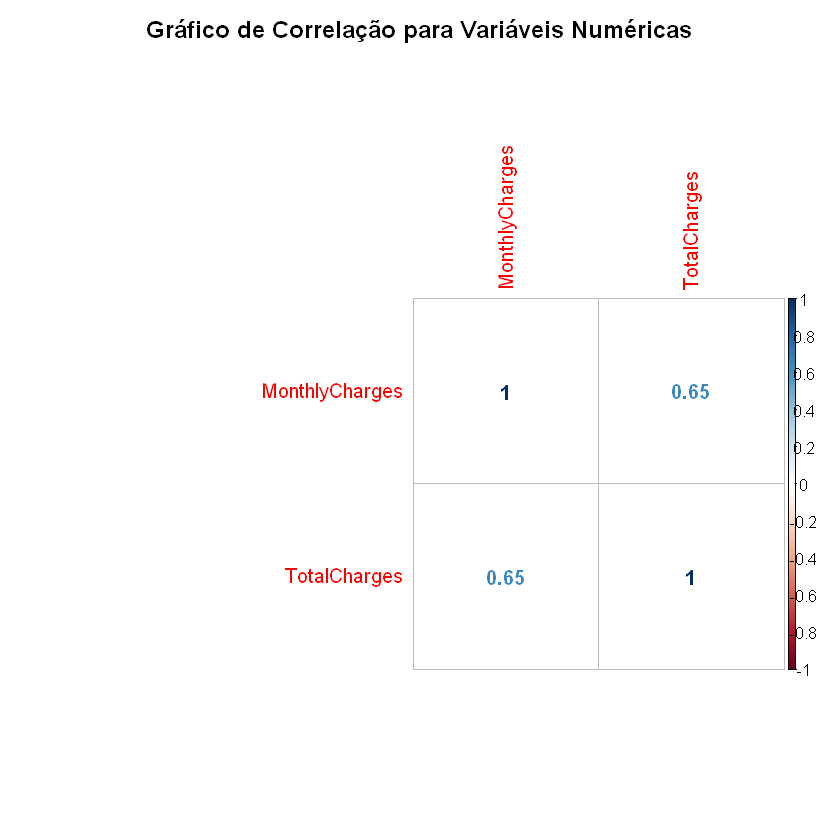

In [19]:
# Correlação entre variáveis numéricas
numeric.var <- sapply(churn, is.numeric)
corr.matrix <- cor(churn[,numeric.var])
corrplot(corr.matrix, main="\n\nGráfico de Correlação para Variáveis Numéricas", method="number")

In [20]:
# Os encargos mensais e os encargos totais estão correlacionados. 
# Então, um deles será removido do modelo. Nós removemos Total Charges.
churn$TotalCharges <- NULL

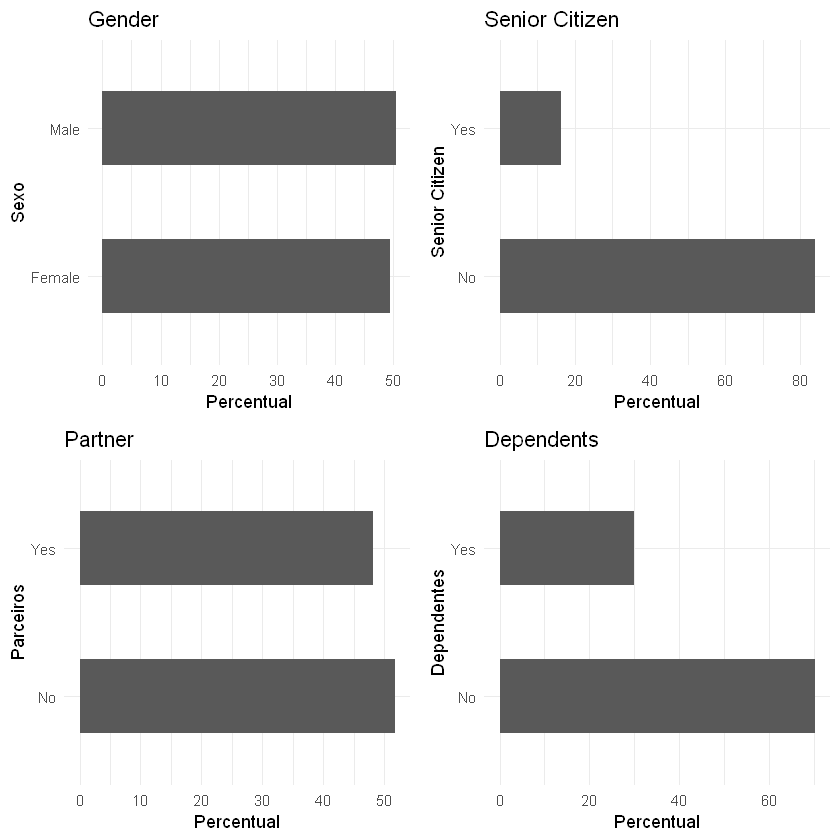

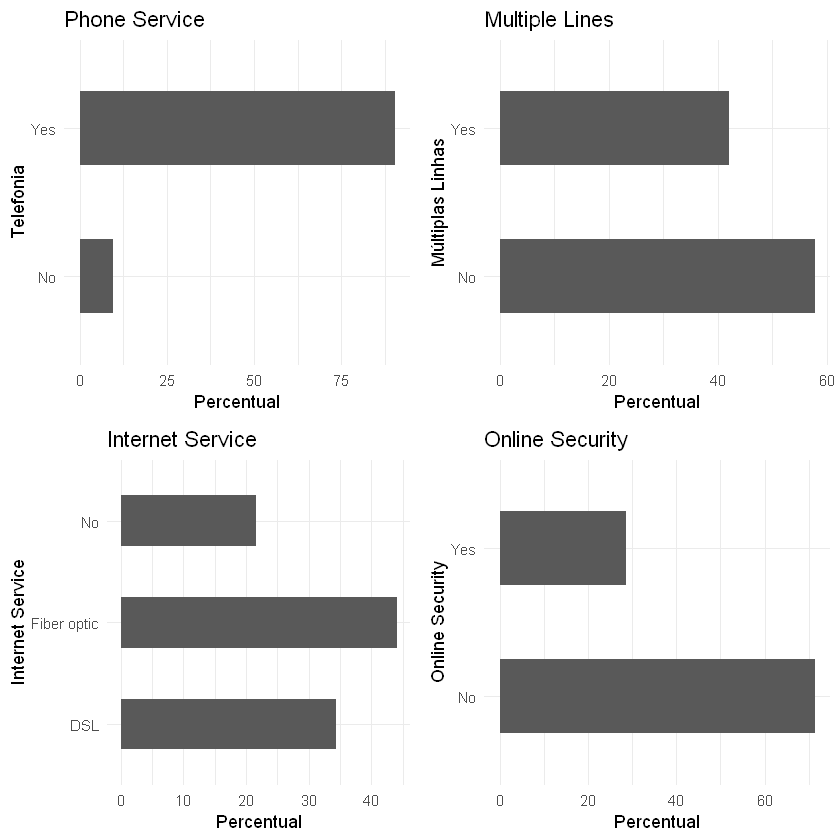

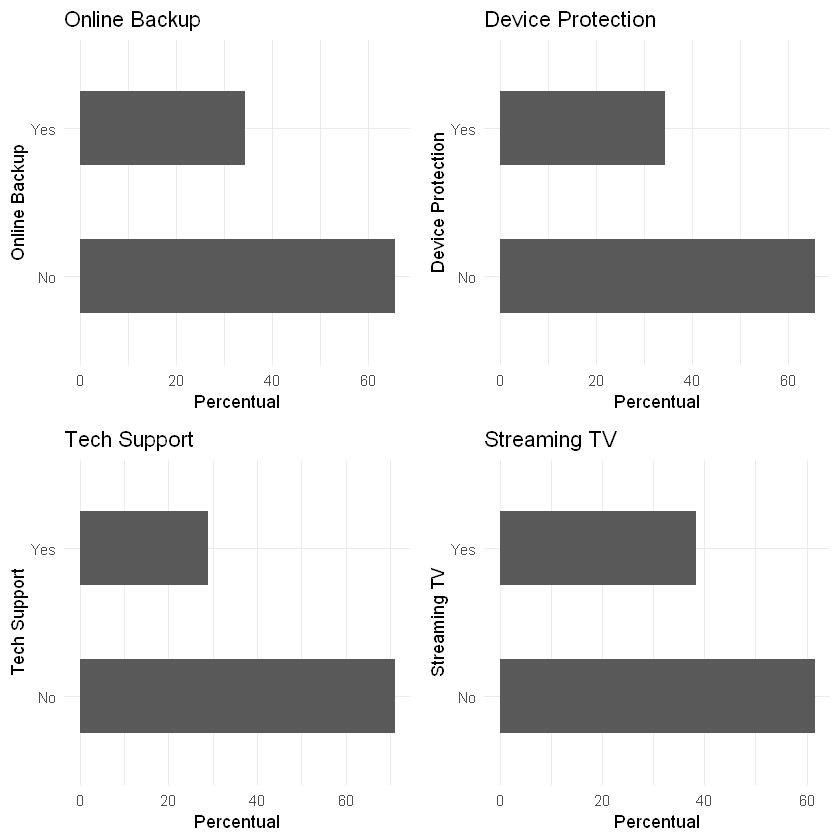

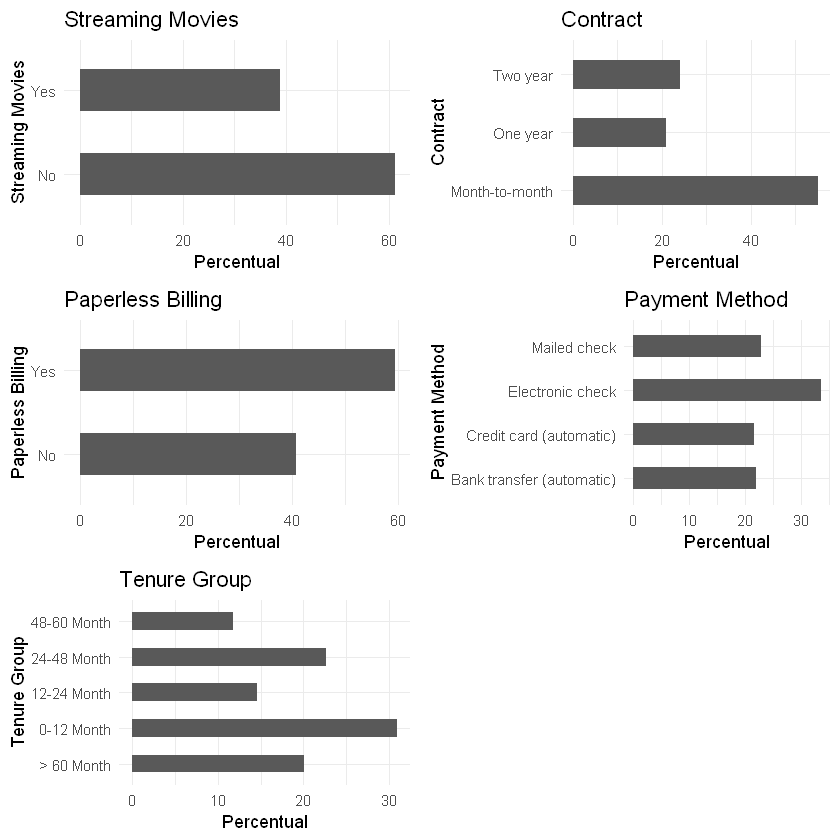

In [21]:
# Gráficos de barra de variáveis categóricas
p1 <- ggplot(churn, aes(x=gender)) + ggtitle("Gender") + xlab("Sexo") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p2 <- ggplot(churn, aes(x=SeniorCitizen)) + ggtitle("Senior Citizen") + xlab("Senior Citizen") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p3 <- ggplot(churn, aes(x=Partner)) + ggtitle("Partner") + xlab("Parceiros") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p4 <- ggplot(churn, aes(x=Dependents)) + ggtitle("Dependents") + xlab("Dependentes") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
grid.arrange(p1, p2, p3, p4, ncol=2)


p5 <- ggplot(churn, aes(x=PhoneService)) + ggtitle("Phone Service") + xlab("Telefonia") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p6 <- ggplot(churn, aes(x=MultipleLines)) + ggtitle("Multiple Lines") + xlab("Múltiplas Linhas") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p7 <- ggplot(churn, aes(x=InternetService)) + ggtitle("Internet Service") + xlab("Internet Service") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p8 <- ggplot(churn, aes(x=OnlineSecurity)) + ggtitle("Online Security") + xlab("Online Security") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
grid.arrange(p5, p6, p7, p8, ncol=2)


p9 <- ggplot(churn, aes(x=OnlineBackup)) + ggtitle("Online Backup") + xlab("Online Backup") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p10 <- ggplot(churn, aes(x=DeviceProtection)) + ggtitle("Device Protection") + xlab("Device Protection") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p11 <- ggplot(churn, aes(x=TechSupport)) + ggtitle("Tech Support") + xlab("Tech Support") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p12 <- ggplot(churn, aes(x=StreamingTV)) + ggtitle("Streaming TV") + xlab("Streaming TV") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
grid.arrange(p9, p10, p11, p12, ncol=2)


p13 <- ggplot(churn, aes(x=StreamingMovies)) + ggtitle("Streaming Movies") + xlab("Streaming Movies") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p14 <- ggplot(churn, aes(x=Contract)) + ggtitle("Contract") + xlab("Contract") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p15 <- ggplot(churn, aes(x=PaperlessBilling)) + ggtitle("Paperless Billing") + xlab("Paperless Billing") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p16 <- ggplot(churn, aes(x=PaymentMethod)) + ggtitle("Payment Method") + xlab("Payment Method") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
p17 <- ggplot(churn, aes(x=tenure_group)) + ggtitle("Tenure Group") + xlab("Tenure Group") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentual") + coord_flip() + theme_minimal()
grid.arrange(p13, p14, p15, p16, p17, ncol=2)

In [22]:
# Todas as variáveis categóricas parecem ter uma distribuição razoavelmente ampla, 
# portanto, todas elas serão mantidas para análise posterior.

##### Modelagem Preditiva ##### 

# Regressão Logística

In [23]:
# Primeiro, dividimos os dados em conjuntos de treinamento e testes
intrain <- createDataPartition(churn$Churn,p=0.7,list=FALSE)
training <- churn[intrain,]
testing <- churn[-intrain,]

In [24]:
# Confirme se a divisão está correta
dim(training); dim(testing)

[1] 4924   19

[1] 2108   19

# Treinando o modelo de regressão logística


In [25]:
#Fitting do Modelo
LogModel <- glm(Churn ~ ., family=binomial(link="logit"), data=training)
print(summary(LogModel))


Call:
glm(formula = Churn ~ ., family = binomial(link = "logit"), data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9601  -0.6632  -0.2783   0.6569   3.1320  

Coefficients:
                                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -1.256926   1.006662  -1.249 0.211809    
genderMale                            0.046692   0.078255   0.597 0.550735    
SeniorCitizenYes                      0.214592   0.101597   2.112 0.034670 *  
PartnerYes                           -0.080018   0.093478  -0.856 0.391993    
DependentsYes                        -0.046023   0.107846  -0.427 0.669566    
PhoneServiceYes                       0.048161   0.791403   0.061 0.951475    
MultipleLinesYes                      0.434077   0.214374   2.025 0.042881 *  
InternetServiceFiber optic            1.704714   0.971180   1.755 0.079208 .  
InternetServiceNo                    -1.658063   0.983696  -1.686 0.091884 .

# Análise de Variância - ANOVA

In [26]:
# Os três principais recursos mais relevantes incluem 
# Contract, tenure_group e PaperlessBilling.
anova(LogModel, test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,4923,5702.760,NA
gender,1,4.324613e-03,4922,5702.755,9.475675e-01
SeniorCitizen,1,1.055026e+02,4921,5597.253,9.477119e-25
Partner,1,1.224901e+02,4920,5474.763,1.803145e-28
Dependents,1,2.779970e+01,4919,5446.963,1.345470e-07
PhoneService,1,4.631058e-01,4918,5446.500,4.961760e-01
MultipleLines,1,2.326991e+00,4917,5444.173,1.271474e-01
InternetService,2,4.921668e+02,4915,4952.006,1.340734e-107
OnlineSecurity,1,1.687023e+02,4914,4783.304,1.421057e-38
OnlineBackup,1,8.702979e+01,4913,4696.274,1.068986e-20


In [27]:
# Analisando a tabela de variância, podemos ver a queda no desvio ao adicionar cada variável 
# uma de cada vez. Adicionar InternetService, Contract e tenure_group reduz 
# significativamente o desvio residual. 
# As outras variáveis, como PaymentMethod e Dependents, parecem melhorar menos o modelo, 
# embora todos tenham valores p baixos.
testing$Churn <- as.character(testing$Churn)
testing$Churn[testing$Churn=="No"] <- "0"
testing$Churn[testing$Churn=="Yes"] <- "1"
fitted.results <- predict(LogModel,newdata=testing,type='response')
fitted.results <- ifelse(fitted.results > 0.5,1,0)
misClasificError <- mean(fitted.results != testing$Churn)
print(paste('Logistic Regression Accuracy',1-misClasificError))

[1] "Logistic Regression Accuracy 0.796015180265655"


In [28]:
# Matriz de Confusão de Regressão Logística
print("Confusion Matrix Para Logistic Regression"); table(testing$Churn, fitted.results > 0.5)

[1] "Confusion Matrix Para Logistic Regression"


   
    FALSE TRUE
  0  1386  162
  1   268  292

# Odds Ratio

In [29]:
# Uma das medidas de desempenho interessantes na regressão logística é Odds Ratio. 
# Basicamente, odds ratio é a chance de um evento acontecer.
exp(cbind(OR=coef(LogModel), confint(LogModel)))

# Para cada aumento de unidade no encargo mensal (Monthly Charge), 
# há uma redução de 2,5% na probabilidade do cliente cancelar a assinatura.

Waiting for profiling to be done...


,OR,2.5 %,97.5 %
(Intercept),0.2845275,0.03949282,2.0455196
genderMale,1.0477989,0.89883598,1.2216016
SeniorCitizenYes,1.2393557,1.01538753,1.5122991
PartnerYes,0.9230994,0.76856782,1.1088196
DependentsYes,0.9550202,0.77255354,1.1792182
PhoneServiceYes,1.0493394,0.22249706,4.9548118
MultipleLinesYes,1.5435378,1.01435633,2.3510166
InternetServiceFiber optic,5.4998136,0.82151222,37.0226084
InternetServiceNo,0.1905077,0.02765046,1.3087917
OnlineSecurityYes,0.7722943,0.50573232,1.1785589


# árvore de Decisão

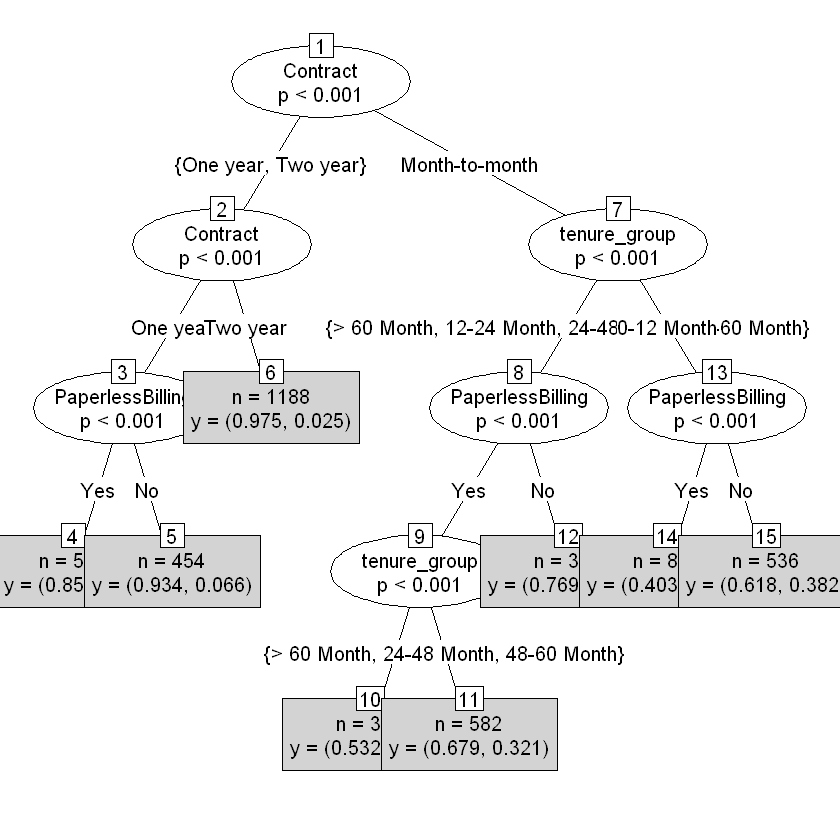

In [30]:
# Visualização da árvore de Decisão
# Para fins de ilustração, vamos usar apenas três variáveis para plotar 
# árvores de decisão, elas são "Contrato", "tenure_group" e "PaperlessBilling".
tree <- ctree(Churn ~ Contract+tenure_group+PaperlessBilling, training)
plot(tree, type='simple')

# 1. Das três variáveis que usamos, o Contrato é a variável mais importante 
# para prever a rotatividade de clientes ou não.
# 2. Se um cliente em um contrato de um ano ou de dois anos, 
# não importa se ele (ela) tem ou não a PapelessBilling, ele (ela) é menos propenso 
# a se cancelar a assinatura.
# 3. Por outro lado, se um cliente estiver em um contrato mensal, 
# e no grupo de posse de 0 a 12 meses, e usando o PaperlessBilling, 
# esse cliente terá mais chances de cancelar a assinatura.


In [31]:
# Matriz de Confusão da árvore de Decisão
# Estamos usando todas as variáveis para tabela de matriz de confusão de produto e fazer previsões.
pred_tree <- predict(tree, testing)
print("Confusion Matrix Para Decision Tree"); table(Predicted = pred_tree, Actual = testing$Churn)

[1] "Confusion Matrix Para Decision Tree"


         Actual
Predicted    0    1
      No  1397  343
      Yes  151  217

In [32]:
# Precisão da árvore de decisão
p1 <- predict(tree, training)
tab1 <- table(Predicted = p1, Actual = training$Churn)
tab2 <- table(Predicted = pred_tree, Actual = testing$Churn)
print(paste('Decision Tree Accuracy',sum(diag(tab2))/sum(tab2)))

[1] "Decision Tree Accuracy 0.765654648956357"


##### Random Forest #####


Call:
 randomForest(formula = Churn ~ ., data = training) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 21.36%
Confusion matrix:
      No Yes class.error
No  3240 375   0.1037344
Yes  677 632   0.5171887


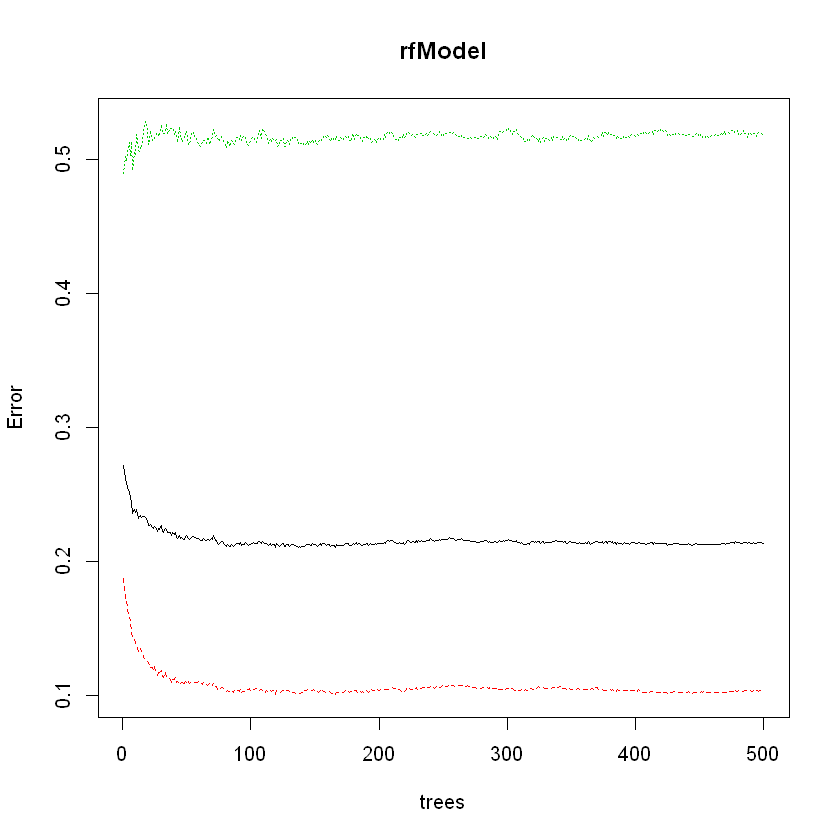

In [33]:
rfModel <- randomForest(Churn ~ ., data = training)
print(rfModel)
plot(rfModel)

# A previsão é muito boa ao prever "Não". 
# A taxa de erros é muito maior quando se prevê "sim".

In [34]:
# Prevendo valores com dados de teste
pred_rf <- predict(rfModel, testing)

In [35]:
# Confusion Matrix
print("Confusion Matrix Para Random Forest"); table(testing$Churn, pred_rf)

[1] "Confusion Matrix Para Random Forest"


   pred_rf
      No  Yes
  0 1385  163
  1  269  291

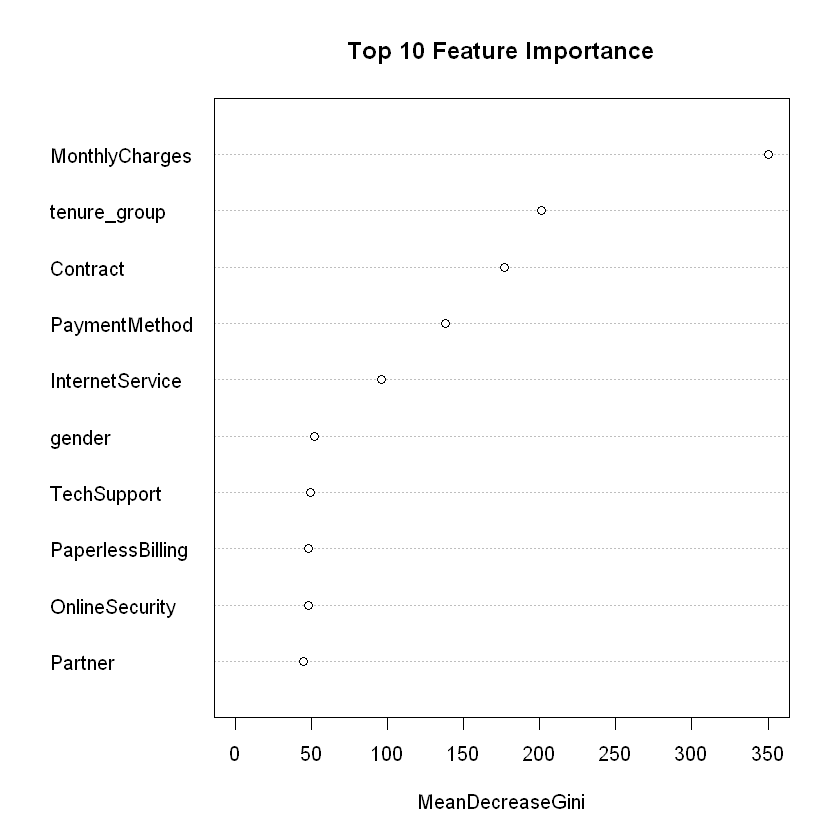

In [36]:
# Recursos mais importantes
varImpPlot(rfModel, sort=T, n.var = 10, main = 'Top 10 Feature Importance')